In [1]:
## hello and welcome to the rscha2d model! mamma mia!

pomelo! mamma mia! spaghetti!

In [2]:
import numpy

import rscha2d
import fibonacci_sphere
import trig
import constants
import coords
import gauge

from matplotlib import pyplot, colors, ticker
import matplotlib
%matplotlib nbagg

In [3]:
matplotlib.rcParams["font.family"] = "Fira Sans"

In [4]:
# db_path = "../data/rscha2d/GlobalDatabase-11Mayo2017.dat"
db_path = "../data/rscha2d/bd_11mayo_naveg_piracy.csv"
filtered_db_path = "../data/rscha2d/bd_11mayo_naveg_piracy.filtered.csv"

In [5]:
#styles
style_hist_good = {"color" : "C0", "edgecolor" : "white"}
style_hist_bad = {"color" : "C3", "edgecolor" : "white"}

In [6]:
lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
knots_bd = numpy.arange(-2100, 2050, 50)

lo primero es filtrar y eso. criterios:
- error demasiado big (en t y en valor)
- 3+ sigmas de distancia al modelo (al sha.dif? a este?)

In [7]:
t_err_max = 250
t_min = -2250

In [8]:
model = rscha2d.Model()
model.set_model_params(theta_c, phi_c, theta_0d,
                       cap_edge=0, kmax_int=3, kmax_ext=3, m_max=2, g10_ref=-30,
                       knots=knots_bd,
                       spatial_reg=1e-5, temporal_reg=1e-3)

In [9]:
model.add_data(db_path)

1096


In [10]:
import geofield
import xyzfield

sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

import scipy
g_interp = scipy.interpolate.interp1d(
    sha.years, sha.gcomp, axis=0, kind="cubic", fill_value="extrapolate")(model.tv)

D_shadif = numpy.empty_like(model.tv)
I_shadif = numpy.empty_like(model.tv)
F_shadif = numpy.empty_like(model.tv)

for i, (year, theta, phi) in enumerate(zip(model.tv, model.thetav, model.phiv)):
    dec,inc,f,h = xyzfield.xyz2difh(*xyzfield.xyzfieldv2(g_interp[i, :],
                                                         numpy.atleast_1d(phi),
                                                         numpy.atleast_1d(theta)))
    D_shadif[i] = dec
    I_shadif[i] = inc
    F_shadif[i] = f
    

In [10]:
style_hist_good = {"color" : "xkcd:black", "edgecolor" : "white"}
style_hist_bad = {"color" : "C3", "edgecolor" : "white"}

<IPython.core.display.Javascript object>


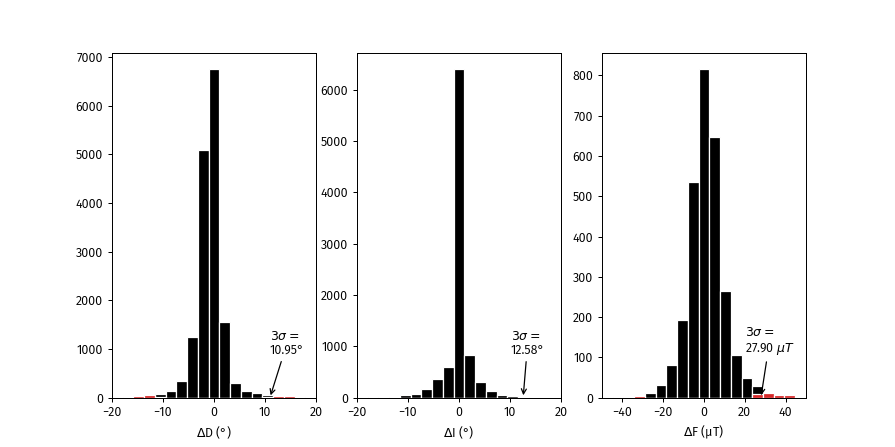

In [11]:
fig, axes = pyplot.subplots(1, 3, figsize=(10,5))

D_res = numpy.rad2deg(trig.mindiff(model.D_o, D_shadif))
I_res = numpy.rad2deg(trig.mindiff(model.I_o, I_shadif))
F_res = model.F_o - F_shadif

D_std = numpy.std(D_res[~numpy.isnan(D_res)])
I_std = numpy.std(I_res[~numpy.isnan(I_res)])
F_std = numpy.std(F_res[~numpy.isnan(F_res)])

D_range = numpy.linspace(-20, 20, 20)
I_range = numpy.linspace(-20, 20, 20)
F_range = numpy.linspace(-50, 50, 20)

axes[0].hist(D_res[~numpy.isnan(D_res)],bins=D_range, **style_hist_good)
axes[0].hist(D_res[numpy.abs(D_res) > 3*D_std], bins=D_range, **style_hist_bad)
axes[0].set_xbound(-20, 20)
axes[1].hist(I_res[~numpy.isnan(I_res)], bins=I_range, **style_hist_good)
axes[1].hist(I_res[numpy.abs(I_res) > 3*I_std], bins=I_range, **style_hist_bad)
axes[1].set_xbound(-20, 20)
axes[2].hist(F_res[~numpy.isnan(F_res)], bins=F_range, **style_hist_good)
axes[2].hist(F_res[numpy.abs(F_res) > 3*F_std], bins=F_range, **style_hist_bad)
axes[2].set_xbound(-50, 50)

axes[0].annotate(f"$3\sigma=$ \n{3*D_std:4.2f}°", xy=(3*D_std, 0), xytext=(0, 35),
                 arrowprops={"arrowstyle" : "->"}, textcoords="offset points")
axes[1].annotate(f"$3\sigma=$ \n{3*I_std:4.2f}°", xy=(3*I_std, 0), xytext=(-10, 35),
                 arrowprops={"arrowstyle" : "->"}, textcoords="offset points")
axes[2].annotate(f"$3\sigma=$ \n{3*F_std:4.2f} $\mu T$", xy=(3*F_std, 0), xytext=(-13, 35),
                 arrowprops={"arrowstyle" : "->"}, textcoords="offset points")

axes[0].set_xlabel("$\Delta$D (°)")
axes[1].set_xlabel("$\Delta$I (°)")
axes[2].set_xlabel("$\Delta$F (μT)")

pyplot.show(fig)

In [12]:
inliers = model.ids[~((numpy.abs(D_res) > 3*D_std) |
                    (numpy.abs(I_res) > 3*I_std) |
                    (numpy.abs(F_res) > 3*F_std) |
                    (model.t_err > 250))]

In [13]:
f = open(db_path, "r")
f2 = open(filtered_db_path, "w")
    
for i, line in enumerate(f):
    if i in inliers:
        f2.write(line)

In [14]:
f.close()
f2.close()

In [15]:
sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

In [16]:
model2 = rscha2d.Model()
model2.set_model_params(theta_c, phi_c, theta_0d,
                        cap_edge=0, kmax_int=3, kmax_ext=3, m_max=2, g10_ref=-30,
                        knots=knots_bd,
                        spatial_reg=1e-4, temporal_reg=1e-3,
                        refmodel={"years" : sha.years,
                                  "coefs" : sha.gcomp[:, :2]})

In [17]:
model2.add_data(filtered_db_path)

226


In [18]:
import geofield
import xyzfield

sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

import scipy
g_interp = scipy.interpolate.interp1d(
    sha.years, sha.gcomp, axis=0, kind="cubic", fill_value="extrapolate")(model2.tv)

D_shadif = numpy.empty_like(model2.tv)
I_shadif = numpy.empty_like(model2.tv)
F_shadif = numpy.empty_like(model2.tv)

for i, (year, theta, phi) in enumerate(zip(model2.tv, model2.thetav, model2.phiv)):
    dec,inc,f,h = xyzfield.xyz2difh(*xyzfield.xyzfieldv2(g_interp[i, :],
                                                         numpy.atleast_1d(phi),
                                                         numpy.atleast_1d(theta)))
    D_shadif[i] = dec
    I_shadif[i] = inc
    F_shadif[i] = f

<IPython.core.display.Javascript object>


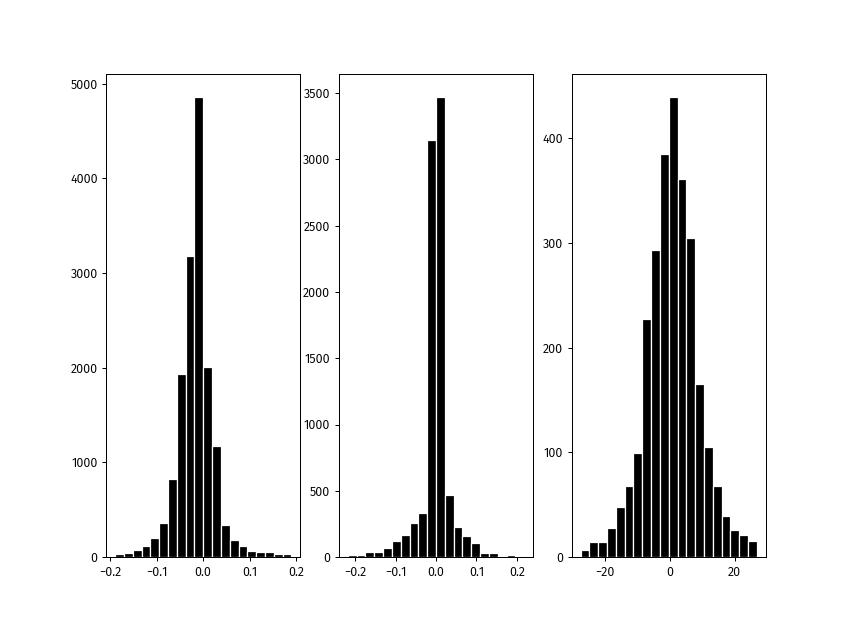

In [19]:
fig, axes = pyplot.subplots(1, 3, figsize=(9.5,7))

D_res = trig.mindiff(model2.D_o, D_shadif)
I_res = trig.mindiff(model2.I_o, I_shadif)
F_res = model2.F_o - F_shadif

axes[0].hist(D_res[~numpy.isnan(D_res)], bins=20, **style_hist_good)
axes[1].hist(I_res[~numpy.isnan(I_res)], bins=20, **style_hist_good)
axes[2].hist(F_res[~numpy.isnan(F_res)], bins=20, **style_hist_good)

pyplot.show(fig)

- the bad data was thrusted into ***oblivion*** ha ha
- cool and nice histogramos

In [20]:
solution = model2.solve(complete=True)
g = solution["coefs"]

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  3.]),
  array([ 0.,  1., -1.,  0.,  2., -2.,  1., -1.,  3., -3.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00,   1.127449e+01,   1.127449e+01,
         8.955337e+00,   8.955337e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  3.]),
  array([ 1., -1.,  0.,  2., -2.,  1., -1.,  3., -3.]),
  array([  3.646726,   3.646726,   7.958865,   6.368397,   6.368397,
        11.274494,  11.274494,   8.955337,   8.955337])), 
array([ 0,  1, -1,  2, -2]), array([ 6366.087515, ...,  6362.715255]), array([ 0.264736, ...,  0.239397]), array([ 1.289396, ...,  2.278571]), 0.4537856055185257, array([ 12.910691, ...,  -7.714995]), array([ 28.869026, ...,  16.588036]), array([ 40.131389, ...,  48.550907]), 55.18894116

In [21]:
solution

{'coefs': array([ 2.21011318,  0.09007055, -0.06722252, ..., -0.06348462,
        -0.02215589,  0.0375015 ]),
 'coefs_reversed': array([  2.21011318e+00,   1.14618270e+00,  -1.03181592e-01, ...,
         -1.83019355e-03,   4.76959178e-02,   3.75015032e-02]),
 'norm_s': 29583.259478013129,
 'norm_t': 1352.4436408273907}

In [22]:
import os
import datetime

now = str(datetime.datetime.now())
dirname = f"../data/rscha2d/rscha2d_{now}"
os.mkdir(dirname)

In [23]:
n_iterations = 100
g_boot = numpy.zeros((len(g), n_iterations))
for i in range(n_iterations):
    model2.wiggle()
    g_boot[:, i] = model2.solve(complete=True)["coefs"]
    print(gauge.gauge(i+1, n_iterations), end="\r")

f = open(f"{dirname}/meta.txt", "w")
f.write(model2.export_params())
f.write(f"n_iterations : {n_iterations}\n")
f.close()
numpy.save(f"{dirname}/coefs.npy", g_boot)

KeyboardInterrupt: 

In [24]:
g_boot = numpy.load("/home/josecper/Programs/data/rscha2d/rscha2d_2017-07-05 14:20:33.275656/coefs.npy")
n_iterations=g_boot.shape[1]

#### lets make a big curve

In [140]:
name_at = "Paris"
theta_at, phi_at = numpy.deg2rad((90-48.8, 2.35))

In [337]:
name_at = "Sofia"
theta_at, phi_at = numpy.deg2rad((90 - 42.69, 23.32))

In [345]:
name_at = "Göttingen"
theta_at, phi_at = numpy.deg2rad((90 - 51.5413, 9.9158))

In [346]:
import importlib; importlib.reload(trig)

<module 'trig' from '/home/josecper/Programs/python/trig.py'>

In [347]:
near = (trig.angulardist(theta_at, phi_at, model2.thetav, model2.phiv) 
        < numpy.arctan(900/constants.a_r))

D_reloc, I_reloc, F_reloc = trig.relocate(model2.D_o, model2.I_o, model2.F_o,
                                          model2.thetav, model2.phiv, theta_at, phi_at)

In [348]:
t_cur = numpy.linspace(-2000, 2000, 400)
t_cur, r_cur, theta_cur, phi_cur = coords.curve_at(t_cur, constants.a_r, theta_at, phi_at)
D_cur_bd, I_cur_bd, F_cur_bd = model2.synth_data(t_cur, r_cur, theta_cur, phi_cur, g)

In [349]:
#método 1
#usar las g obtenidas para generar las cosas

D_cur_boot = numpy.zeros((len(D_cur_bd), n_iterations))
I_cur_boot = D_cur_boot.copy()
F_cur_boot = D_cur_boot.copy()

for i in range(n_iterations):
    D_cur_boot[:, i], I_cur_boot[:,i], F_cur_boot[:,i] = (
        model2.synth_data(t_cur, r_cur, theta_cur, phi_cur, g_boot[:,i])
    )
    print(gauge.gauge(i+1, n_iterations), end="\r")
    
D_avg = numpy.average(D_cur_boot, axis=1)
I_avg = numpy.average(I_cur_boot, axis=1)
F_avg = numpy.average(F_cur_boot, axis=1)

D_std = numpy.std(D_cur_boot, axis=1)
I_std = numpy.std(I_cur_boot, axis=1)
F_std = numpy.std(F_cur_boot, axis=1)

In [350]:
#método 2
#extraer las desviaciones de g y usarlas para perturbar g
#no tiene ninguna explicación pero es más "atractivo"

#g_std = numpy.std(g_boot, axis=1)

#D_cur_boot = numpy.zeros((len(D_cur_bd), n_iterations))
#I_cur_boot = D_cur_boot.copy()
#F_cur_boot = D_cur_boot.copy()

#D_avg, I_avg, F_avg = model2.synth_data(t_cur, r_cur, theta_cur, phi_cur, g)

#for i in range(n_iterations):
#    D_cur_boot[:, i], I_cur_boot[:,i], F_cur_boot[:,i] = (
#        model2.synth_data(t_cur, r_cur, theta_cur, phi_cur,g+g_std*numpy.random.randn(*g.shape))
#    )
#    print(gauge.gauge(i+1, n_iterations), end="\r")

#D_std = numpy.std(D_cur_boot, axis=1)
#I_std = numpy.std(I_cur_boot, axis=1)
#F_std = numpy.std(F_cur_boot, axis=1)

In [351]:
g_interp = scipy.interpolate.interp1d(
    sha.years, sha.gcomp, axis=0, kind="cubic", fill_value="extrapolate")(t_cur)

D_shadif = numpy.empty_like(t_cur)
I_shadif = numpy.empty_like(t_cur)
F_shadif = numpy.empty_like(t_cur)

for i, (year, theta, phi) in enumerate(zip(t_cur, theta_cur, phi_cur)):
    dec,inc,f,h = xyzfield.xyz2difh(*xyzfield.xyzfieldv2(g_interp[i, :],
                                                         numpy.atleast_1d(phi),
                                                         numpy.atleast_1d(theta)))
    D_shadif[i] = dec
    I_shadif[i] = inc
    F_shadif[i] = f

<IPython.core.display.Javascript object>


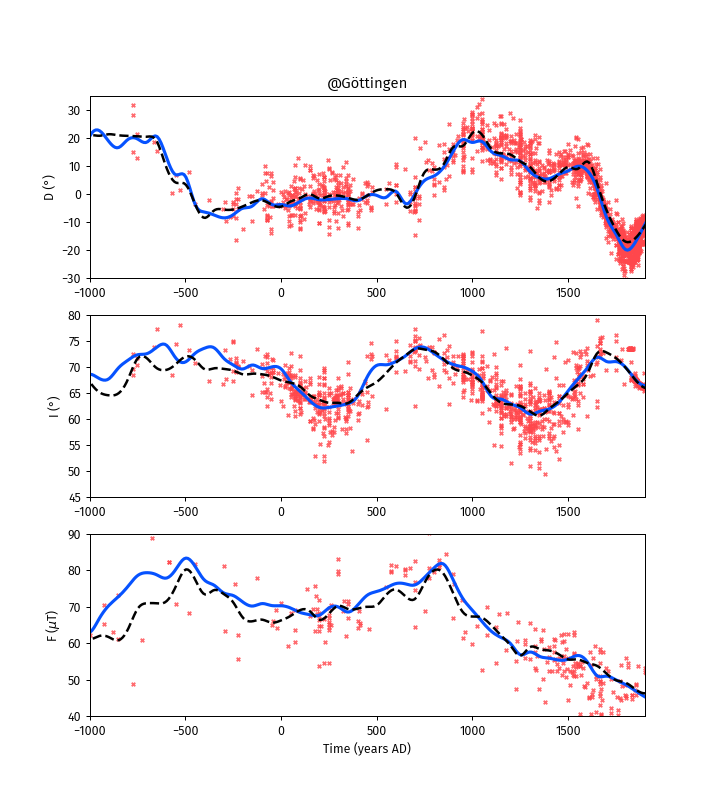

In [352]:
matplotlib.rcParams.update({'font.size': 10})
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(8,9))

common={"marker" : "x", "s" : 8, "alpha" : 0.8, "color" : "xkcd:light red"}
sha_style = {"color" : "xkcd:black", "linestyle" : "--", "linewidth" : 2}
rscha_style = {"color" : "C4", "alpha" : 0.005}

curve_color = "xkcd:electric blue"
curve_style = {"color" : curve_color, "linewidth" : 2.5}
error_style = {"color" : curve_color, "linestyle" : "--"}
fill_style = {"color" : "xkcd:cream", "alpha" : 1.0}

ax0.set_ylabel("D (°)")
ax1.set_ylabel("I (°)")
ax2.set_ylabel("F ($\mu $T)")
ax0.set_title("@{}".format(name_at))

ax0.plot(t_cur, numpy.rad2deg(D_avg), **curve_style)
ax1.plot(t_cur, numpy.rad2deg(I_avg), **curve_style)
ax2.plot(t_cur, F_avg, **curve_style)

#ax0.plot(t_cur, numpy.rad2deg(D_avg+2*D_std), **error_style)
#ax0.plot(t_cur, numpy.rad2deg(D_avg-2*D_std), **error_style)
#ax0.fill_between(t_cur, numpy.rad2deg(D_avg+2*D_std), numpy.rad2deg(D_avg-2*D_std), **fill_style)
ax0.plot(t_cur, numpy.rad2deg(D_shadif), **sha_style)
ax0.scatter(model2.tv[near], numpy.rad2deg(D_reloc)[near],
            label="Nearby data (closer than 900 km)", **common)
ax0.set_ybound(-30, 35)

#ax1.plot(t_cur, numpy.rad2deg(I_avg+2*I_std), **error_style)
#ax1.plot(t_cur, numpy.rad2deg(I_avg-2*I_std), **error_style)
#ax1.fill_between(t_cur, numpy.rad2deg(I_avg+2*I_std), numpy.rad2deg(I_avg-2*I_std), **fill_style)
ax1.plot(t_cur, numpy.rad2deg(I_shadif), **sha_style)
ax1.scatter(model2.tv[near], numpy.rad2deg(I_reloc)[near], **common)
ax1.set_ybound(45, 80)

#ax2.plot(t_cur, F_avg+2*F_std, **error_style)
#ax2.plot(t_cur, F_avg-2*F_std, **error_style)
#ax2.fill_between(t_cur, F_avg+2*F_std, F_avg-2*F_std, **fill_style)
ax2.plot(t_cur, F_shadif, **sha_style)
ax2.scatter(model2.tv[near], F_reloc[near], **common)
ax2.set_ybound(40, 90)
ax2.set_xlabel("Time (years AD)")
    
for ax in (ax0, ax1, ax2):
    ax.set_xbound(-1000, 1900)

fig.savefig(f"../data/rscha2d/{name_at}_curve_boot.png")

In [301]:
n_knots = len(model2.knots)
n_degrees = (len(model2.k_int)
             + len(model2.k_ext)
             + len(model2.m_mehler))
mreg = model2.regularization_matrix()

def l1_norm(g_reversed):
    g = numpy.concatenate(g_reversed.reshape(n_degrees,n_knots).T)
    D, I, F = model2.synth_data(model2.tv, model2.r_geo, model2.theta_geo, model2.phi_geo, g)
    D_res = trig.mindiff(D, model2.D_w)
    I_res = trig.mindiff(I, model2.I_w)
    F_res = (F - model2.F_w)/model2.F_dip
    D_res = D_res[~numpy.isnan(D_res)]
    I_res = I_res[~numpy.isnan(I_res)]
    F_res = F_res[~numpy.isnan(F_res)]
    norm = (numpy.abs(numpy.concatenate((D_res, I_res, F_res))).sum()
            + g_reversed @ mreg @ g_reversed)
    return norm
    

In [320]:
import coords
import scha
import fibonacci_sphere
from mpl_toolkits.basemap import Basemap
import field_plots

times_long = numpy.arange(-1000, 2200, 400)
#times_long = numpy.arange(-1000, 2200, 500)

theta_in, phi_in = fibonacci_sphere.grid(n=12000)
in_cap = trig.angulardist(theta_in, phi_in, theta_c, phi_c) < model2.theta_0p
theta_in = theta_in[in_cap]
phi_in = phi_in[in_cap]

rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)

lon_c, lat_c = numpy.rad2deg((phi_c, numpy.pi/2 - theta_c))
base_cap = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-numpy.rad2deg(model2.theta_0p))
base_world = Basemap(projection="aeqd", lon_0 = lon_c, lat_0 = lat_c, lat_ts=45.0,
                    width=base_cap.xmax, height=base_cap.ymax, resolution="l")

20.0 42.0


<IPython.core.display.Javascript object>


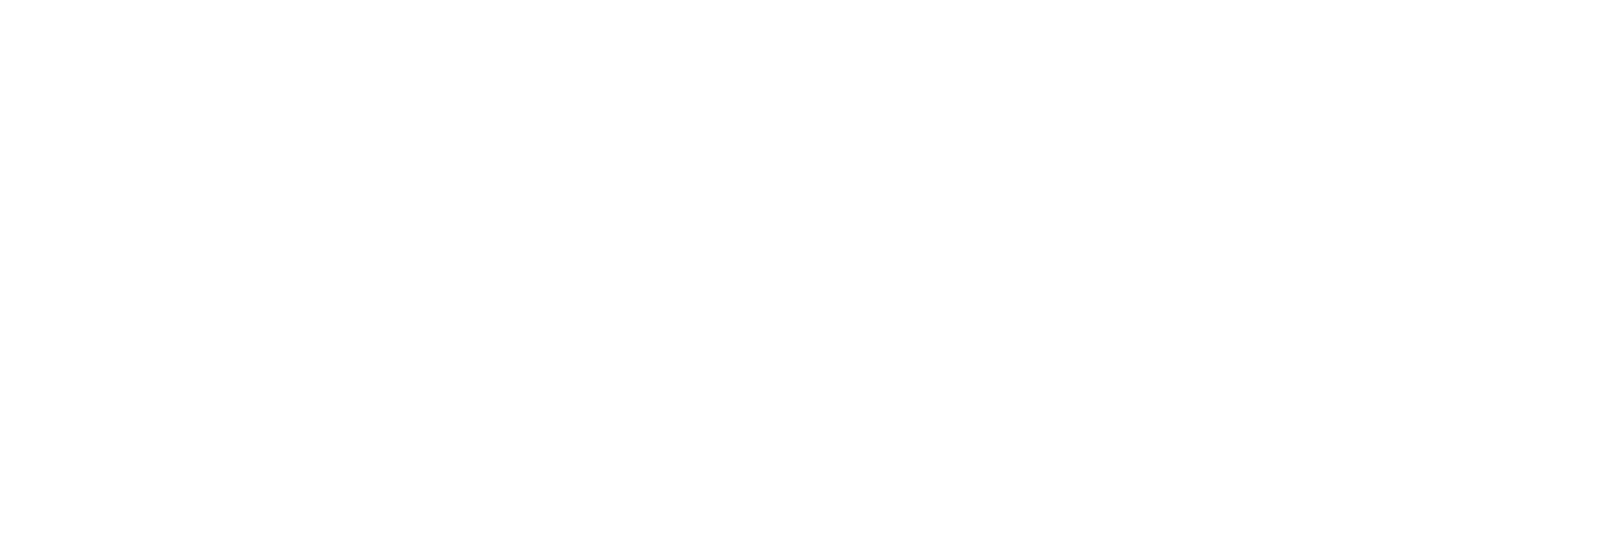

20.0 42.0


<IPython.core.display.Javascript object>


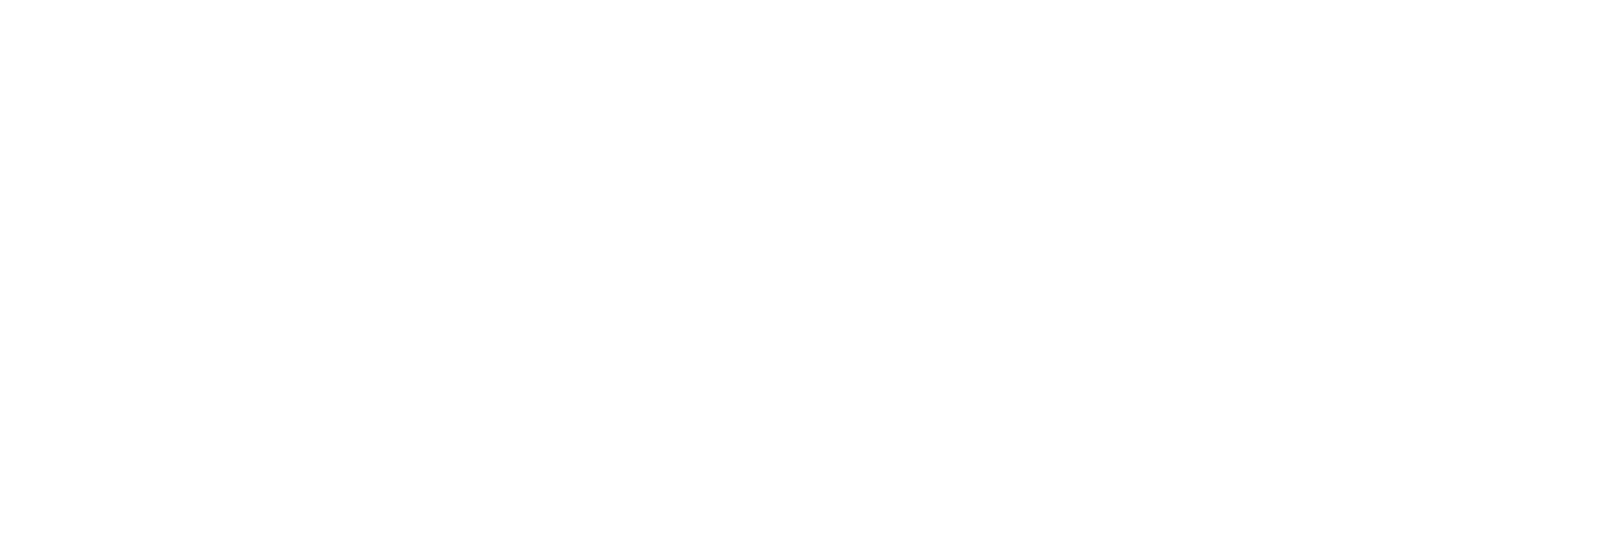

20.0 42.0


<IPython.core.display.Javascript object>


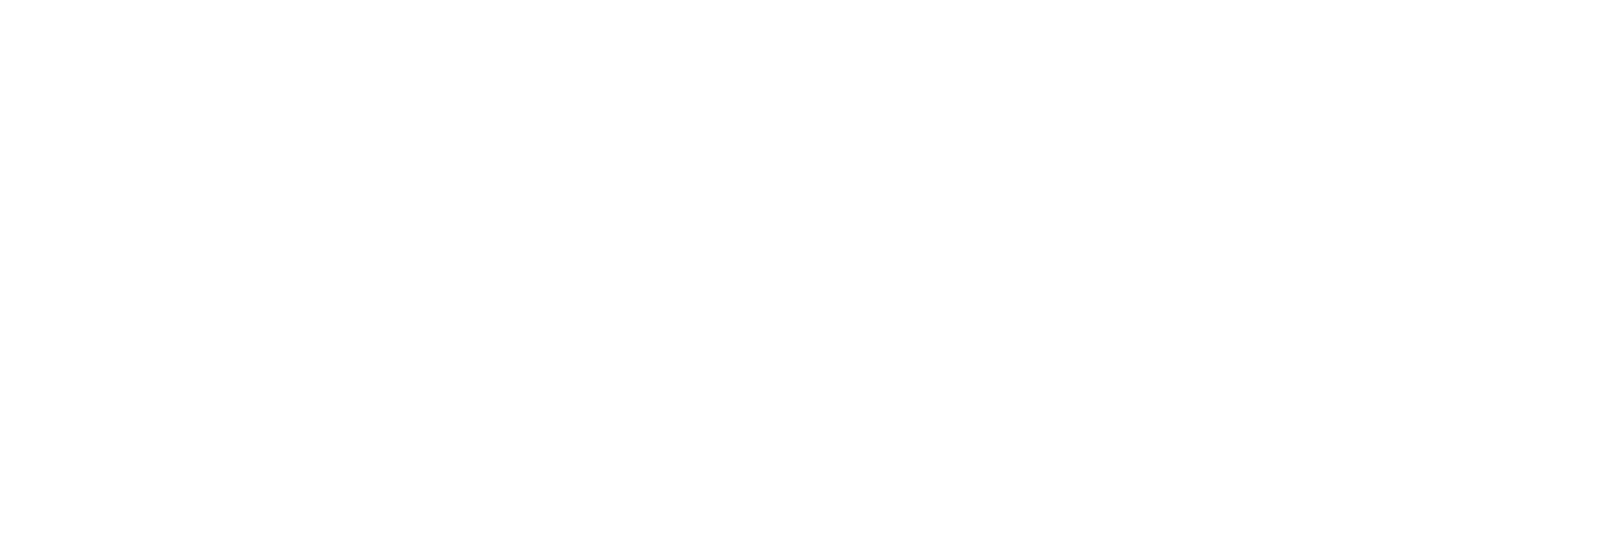

20.0 42.0


<IPython.core.display.Javascript object>


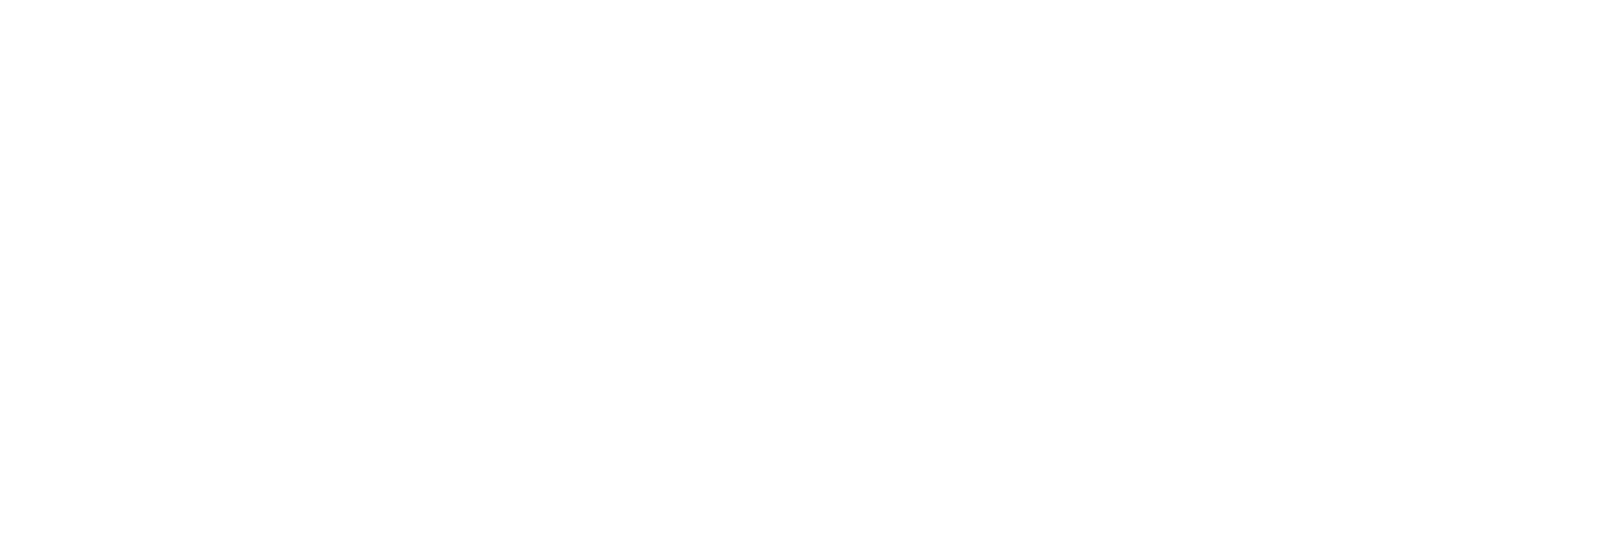

20.0 42.0


<IPython.core.display.Javascript object>


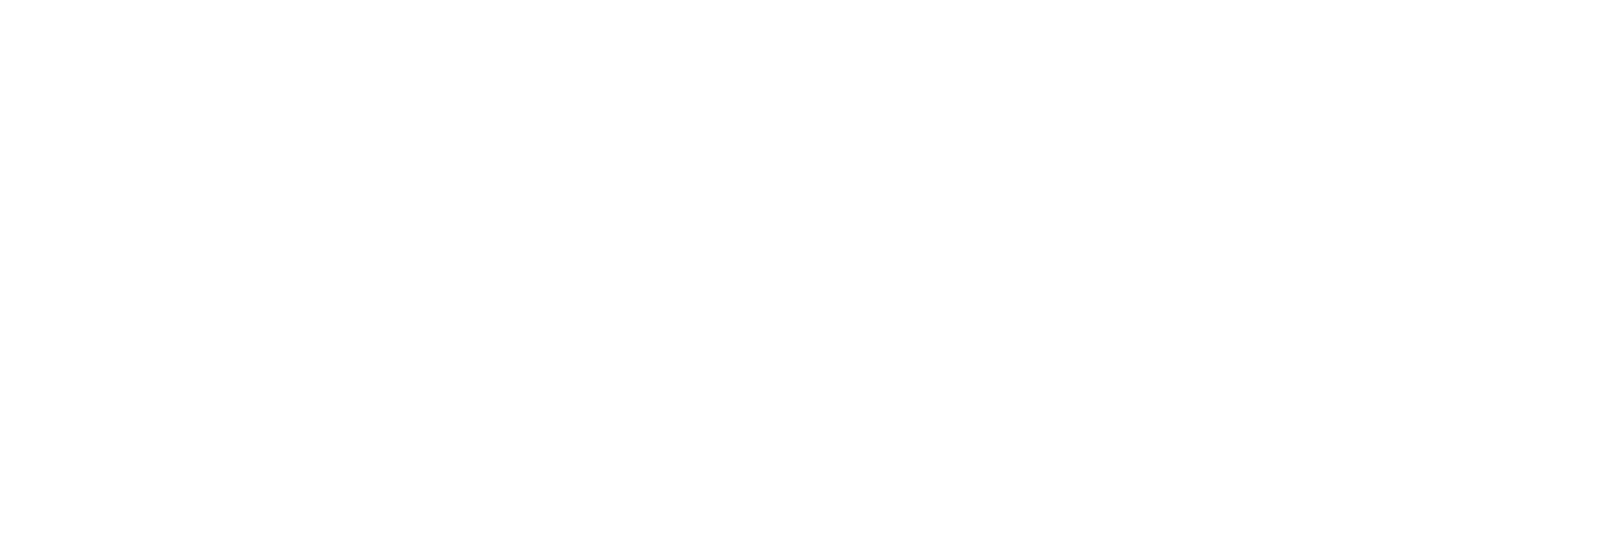

20.0 42.0


<IPython.core.display.Javascript object>


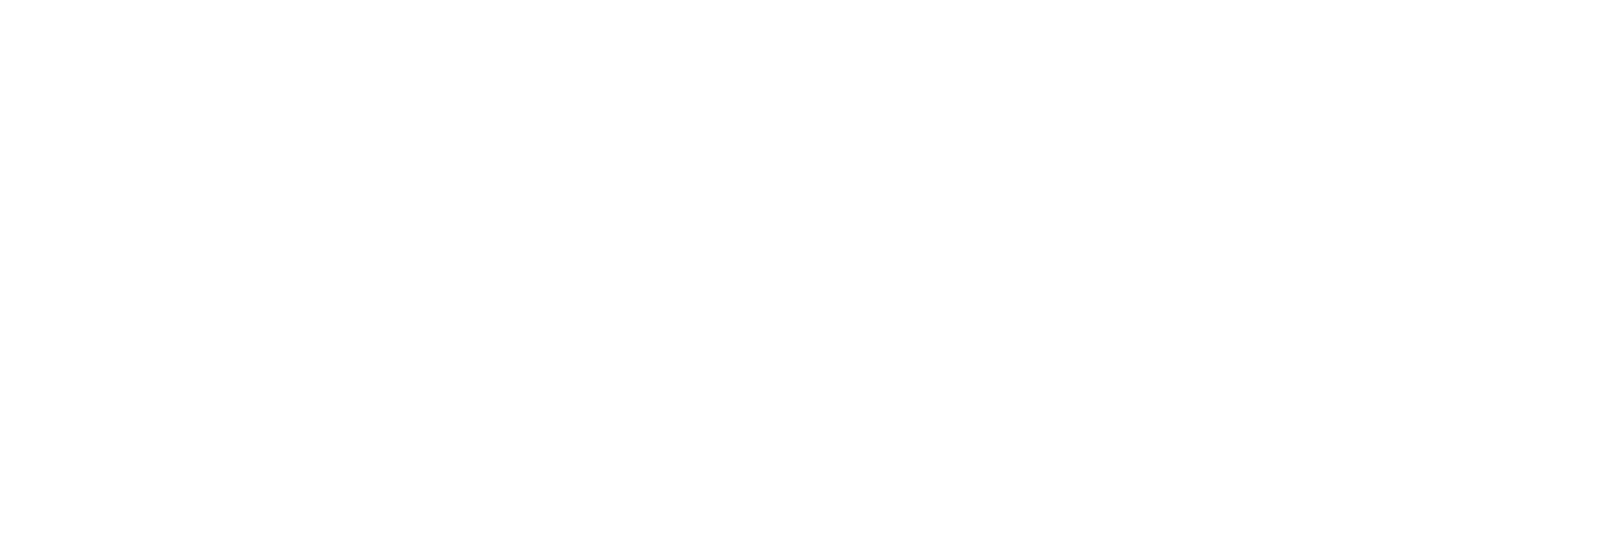

20.0 42.0


<IPython.core.display.Javascript object>


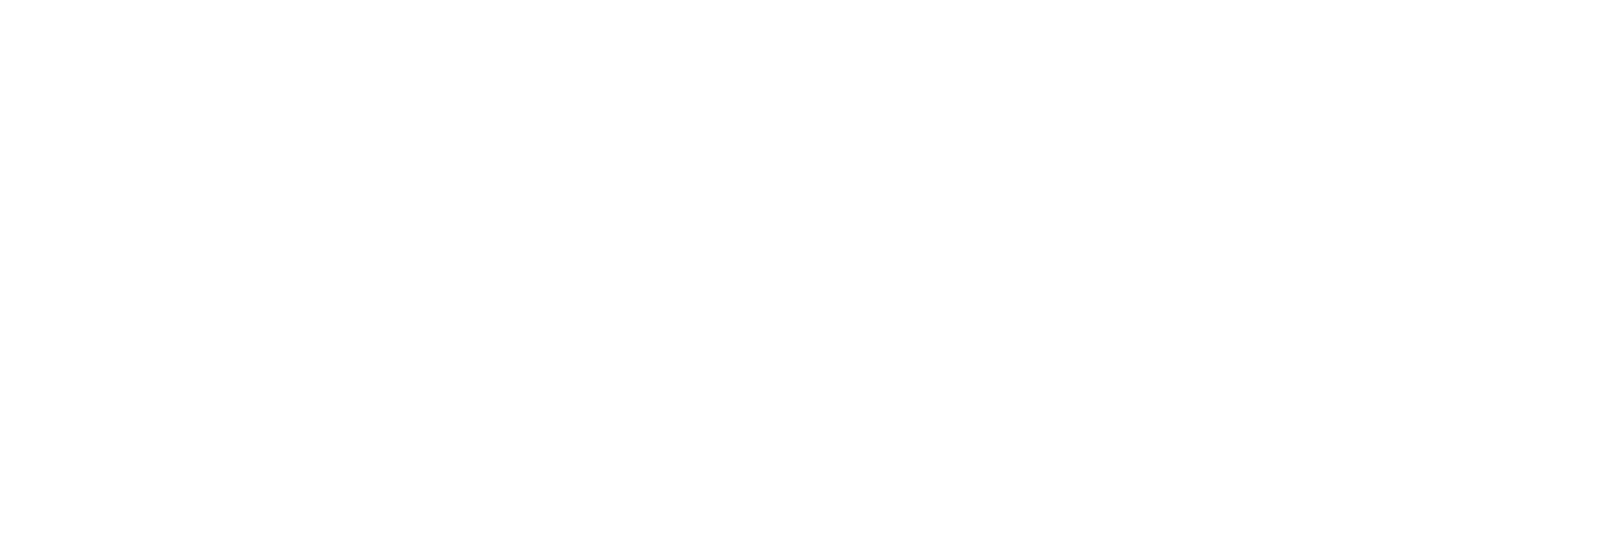

20.0 42.0


<IPython.core.display.Javascript object>


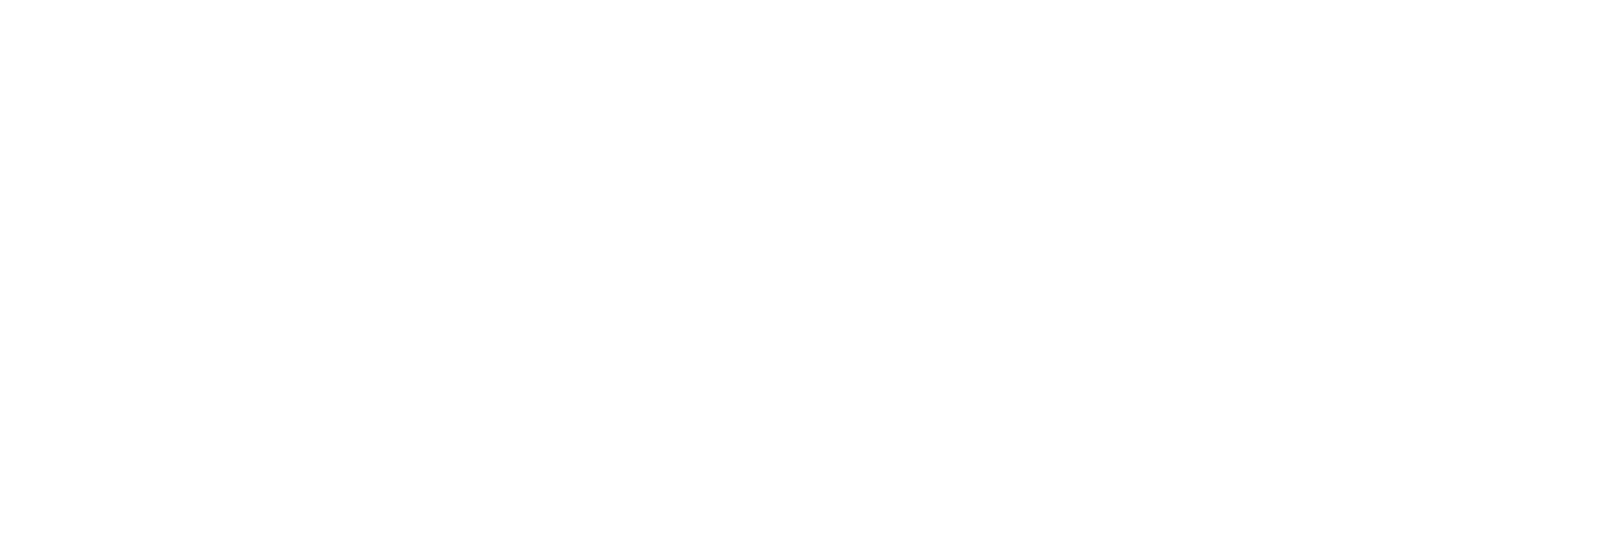

In [326]:
matplotlib.rcParams.update({'font.size': 20})

for jj, time in enumerate(times_long):

    timev = numpy.atleast_1d(time)
    times_d, r_d, theta_d, phi_d = coords.anything(numpy.ones_like(theta_in)
                                                   *constants.a_r,
                                                   theta_in,
                                                   phi_in,
                                                   timev)

    r_dg, theta_dg, phi_dg = trig.geo2sph(theta_d, phi_d)
    r_dgr, theta_dgr, phi_dgr = scha.rotate_coords(r_dg, theta_dg, 
                                                   phi_dg, rot_mat)
    
    D_m, I_m, F_m = model2.synth_data(times_d, r_d, theta_d, phi_d, g)
    
    fig = field_plots.component_residual_plot(
                    theta_dgr, phi_dgr,
                    model2.theta_0p,
                    theta_c, phi_c,
                    (numpy.rad2deg(D_m), numpy.rad2deg(I_m), F_m),
                    scales=("symmetric", "positive", "positive"),
                    cmaps=("Spectral", "Spectral", "Spectral"),
                    titles=("", "", ""),
                    cbar=False,
                    lines=0, nlevels=25,
                    lims=((-50, 50), (0, 90), (30, 80)))
    #fig.suptitle('t = {} years AD'.format(time))
    fig.savefig('../data/rscha2d/mapas_2/rscha2d_{jj:04d}_{time:d}.png'.format(jj=jj, time=int(time)),
                frameon=True)
    pyplot.close(fig)

<IPython.core.display.Javascript object>


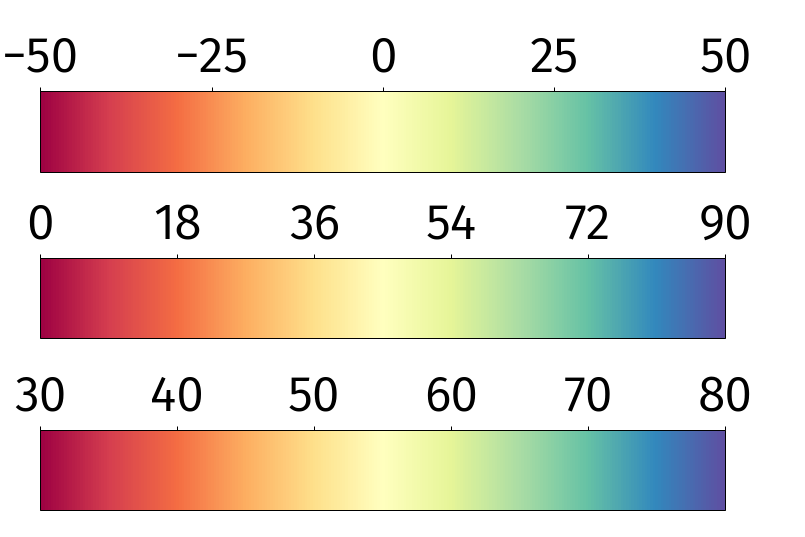

In [334]:
#### Make a figure and axes with dimensions as desired.
import matplotlib
matplotlib.rcParams.update({'font.size': 40})

fig = pyplot.figure(figsize=(9, 6))
ax1 = fig.add_axes([0.05, 0.68, 0.85, 0.15])
ax2 = fig.add_axes([0.05, 0.37, 0.85, 0.15])
ax3 = fig.add_axes([0.05, 0.05, 0.85, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = matplotlib.cm.Spectral
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=matplotlib.colors.Normalize(vmin=-50, vmax=50),
                                ticks = numpy.arange(-50, 75, 25),
                                ticklocation="top",
                                orientation='horizontal')
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=matplotlib.colors.Normalize(vmin=-0, vmax=90),
                                ticks = numpy.arange(0, 108, 18),
                                ticklocation="top",
                                orientation='horizontal')
cb3 = matplotlib.colorbar.ColorbarBase(ax3, cmap=cmap,
                                norm=matplotlib.colors.Normalize(vmin=30, vmax=80),
                                ticks = numpy.arange(30, 90, 10),
                                ticklocation="top",
                                orientation='horizontal')

In [303]:

print("""big dinks
in the heat of the night
darkness swells
engorged potluck spilling everywhere
death happening
just outside of view
or in the phosphenes themselves
i don't know""")

big dinks
in the heat of the night
darkness swells
engorged potluck spilling everywhere
death happening
just outside of view
or in the phosphenes themselves
i don't know


In [304]:
D, I, F = model2.synth_data(model2.tv, model2.r_geo, model2.theta_geo, model2.phi_geo, g)
D_res = trig.mindiff(D, model2.D_w)
I_res = trig.mindiff(I, model2.I_w)
F_res = F - model2.F_w
D_res = D_res[~numpy.isnan(D_res)]
I_res = I_res[~numpy.isnan(I_res)]
F_res = F_res[~numpy.isnan(F_res)]

<IPython.core.display.Javascript object>


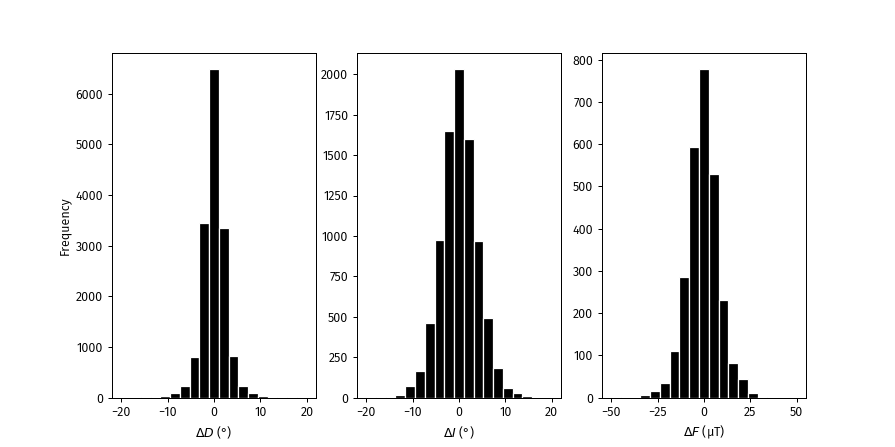

In [305]:
fig, axes = pyplot.subplots(1, 3, figsize=(10,5))

axes[0].hist(numpy.rad2deg(D_res), bins=D_range, **style_hist_good)
axes[1].hist(numpy.rad2deg(I_res), bins=I_range, **style_hist_good)
axes[2].hist(F_res, bins=F_range, **style_hist_good)

axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("$\Delta D$ (°)")
axes[1].set_xlabel("$\Delta I$ (°)")
axes[2].set_xlabel("$\Delta F$ (μT)")

pyplot.show(fig)

<IPython.core.display.Javascript object>


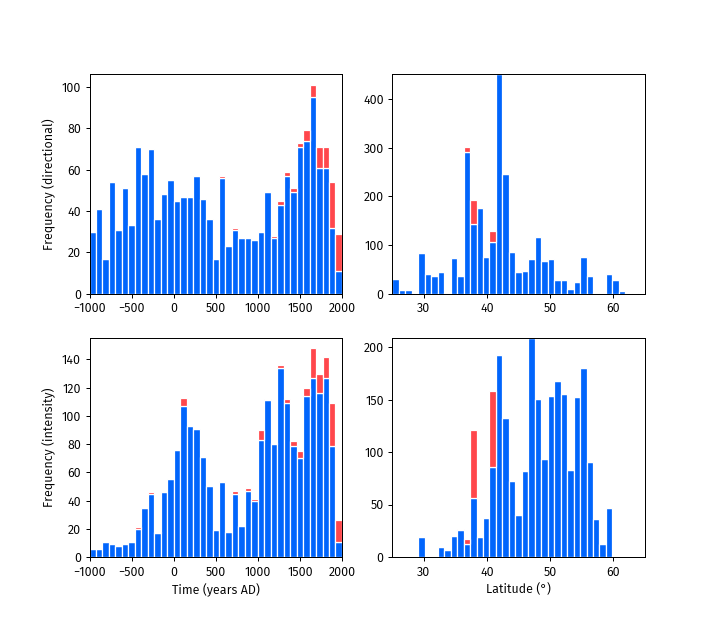

In [306]:
fig, axes = pyplot.subplots(2, 2, figsize=(8,7))

axes[0][0].hist((model2.tv[~model2.instrumental & ~model2.volcanic & ~model2.nan_F],
              model2.tv[model2.volcanic & ~model2.nan_F],
              ),
             bins = numpy.linspace(-1000,2000,40),
             histtype="barstacked",
             color=("xkcd:bright blue", "xkcd:light red"), edgecolor="white")

axes[0][1].hist((model2.lat[~model2.instrumental & ~model2.volcanic & ~model2.nan_F],
              model2.lat[model2.volcanic & ~model2.nan_F],
              ),
             bins = numpy.linspace(25,65,40),
             histtype="barstacked",
             color=("xkcd:bright blue", "xkcd:light red"), edgecolor="white")

axes[1][0].hist((model2.tv[(~model2.instrumental & ~model2.volcanic) & (~model2.nan_D | ~model2.nan_I)],
              model2.tv[model2.volcanic & (~model2.nan_D | ~model2.nan_I)],
              ),
             bins = numpy.linspace(-1000,2000,40),
             histtype="barstacked",
             color=("xkcd:bright blue", "xkcd:light red"), edgecolor="white")

axes[1][1].hist((model2.lat[(~model2.instrumental & ~model2.volcanic) & (~model2.nan_D | ~model2.nan_I)],
              model2.lat[model2.volcanic & (~model2.nan_D | ~model2.nan_I)],
              ),
             bins = numpy.linspace(25,65,40),
             histtype="barstacked",
             color=("xkcd:bright blue", "xkcd:light red"), edgecolor="white")

axes[0][0].set_xbound(-1000, 2000)
axes[0][0].set_ylabel("Frequency (directional)")

axes[0][1].set_xbound(25, 65)
axes[1][0].set_xbound(-1000, 2000)
axes[1][0].set_ylabel("Frequency (intensity)")
axes[1][0].set_xlabel("Time (years AD)")

axes[1][1].set_xbound(25, 65)
axes[1][1].set_xlabel("Latitude (°)")

pyplot.show(fig)

<IPython.core.display.Javascript object>


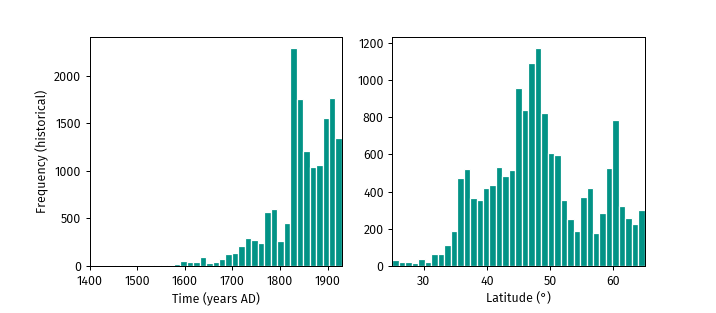

In [307]:
matplotlib.rcParams.update({'font.size': 10})
fig, axes = pyplot.subplots(1, 2, figsize=(8,3.5))

axes[0].hist(model2.tv[model2.instrumental],
             bins = numpy.linspace(1400,1930,40),
             histtype="barstacked",
             color=("xkcd:teal"), edgecolor="white")
axes[0].set_xbound(1400, 1930)
axes[0].set_xlabel("Time (years AD)")
axes[0].set_ylabel("Frequency (historical)")

axes[1].hist(model2.lat[model2.instrumental],
             bins = numpy.linspace(25,65,40),
             histtype="barstacked",
             color=("xkcd:teal"), edgecolor="white")

axes[1].set_xbound(25, 65)
axes[1].set_xlabel("Latitude (°)")
fig.subplots_adjust(bottom=0.15)

<IPython.core.display.Javascript object>


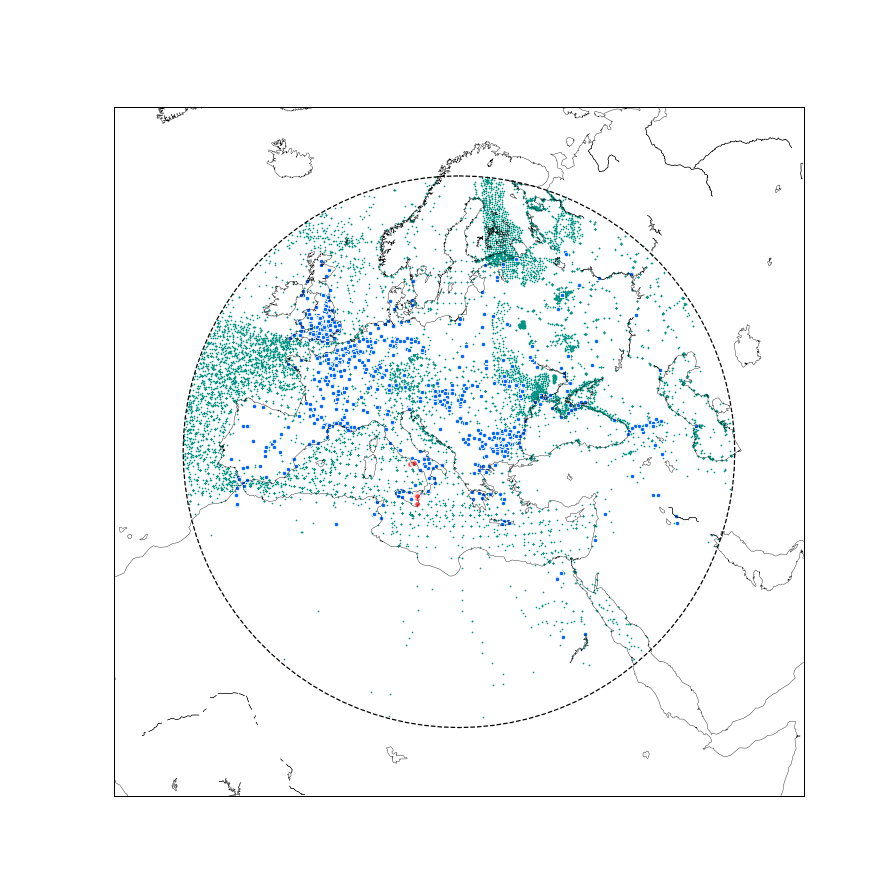

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [308]:
from mpl_toolkits import basemap

#direcciones
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

archaeo_style = {"s": 12, "c" : "xkcd:bright blue", "edgecolor" : "white", "linewidth":0.6}
volcanic_style = {"s": 19, "c" : "xkcd:light red", "edgecolor" : "white", "linewidth":0.6}
instrumental_style = {"marker" : ".", "s": 7, "c" : "xkcd:teal", "edgecolor" : "white", "linewidth":0}

fig, ax = pyplot.subplots(figsize=(10,10))
base = basemap.Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-numpy.rad2deg(theta_0d*1.25))
base2 = basemap.Basemap(projection="aeqd", lon_0 = lon_c, lat_0 = lat_c, lat_ts=26,
                        width=base.xmax, height=base.ymax, resolution="l")
base2.drawcoastlines(ax=ax, linewidth=0.3)

base2.scatter(model2.lon[(~model2.nan_D | ~model2.nan_I) & model2.instrumental & (model2.tv > -1000)],
              model2.lat[(~model2.nan_D | ~model2.nan_I) & model2.instrumental & (model2.tv > -1000)],
              latlon=True, label="Historical", **instrumental_style)
base2.scatter(model2.lon[(~model2.nan_D | ~model2.nan_I) & ~model2.volcanic & 
                         ~model2.instrumental & (model2.tv > -1000)],
              model2.lat[(~model2.nan_D | ~model2.nan_I) & ~model2.volcanic & 
                         ~model2.instrumental & (model2.tv > -1000)],
              latlon=True, label="Archaeomagnetic", **archaeo_style)
base2.scatter(model2.lon[(~model2.nan_D | ~model2.nan_I) & model2.volcanic & (model2.tv > -1000)],
              model2.lat[(~model2.nan_D | ~model2.nan_I) & model2.volcanic & (model2.tv > -1000)],
              latlon=True, label="Volcanic", **volcanic_style)

base2.tissot(lon_c, lat_c, numpy.rad2deg(theta_0d), 100,
             facecolor="none", edgecolor="black", linestyle="dashed")

#ax.set_title(r"$\lambda_c = {}°, \phi_c = {}°, \lambda_0 = {}°$".format(lat_c, lon_c, numpy.rad2deg(theta_0d)))
#ax.legend()
pyplot.show(fig)
fig.savefig("../data/rscha2d/directions_map.png", frameon=False)

<IPython.core.display.Javascript object>


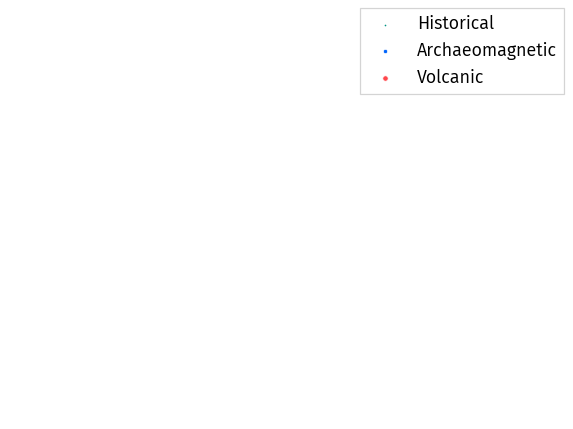

In [309]:
fig = pyplot.figure()

fig.legend(*ax.get_legend_handles_labels(), fancybox=False, fontsize="x-large")

<IPython.core.display.Javascript object>


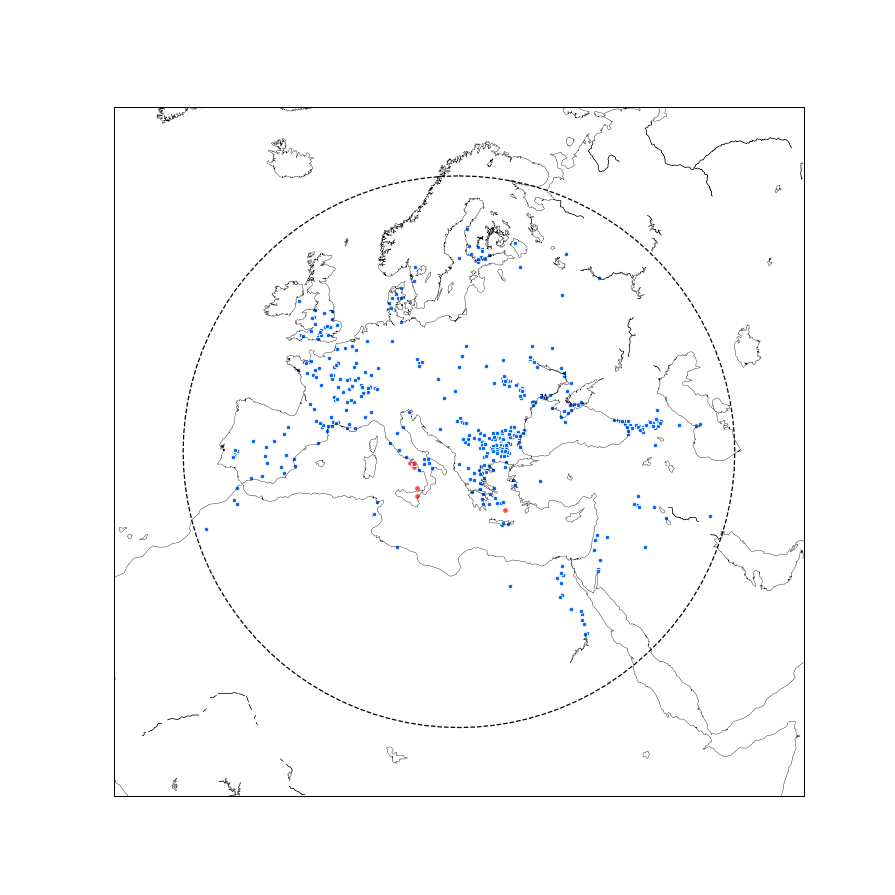

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [310]:
from mpl_toolkits import basemap

#direcciones
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

archaeo_style = {"s": 12, "c" : "xkcd:bright blue", "edgecolor" : "white", "linewidth":0.6}
volcanic_style = {"s": 19, "c" : "xkcd:light red", "edgecolor" : "white", "linewidth":0.6}
instrumental_style = {"marker" : ".", "s": 7, "c" : "xkcd:teal", "edgecolor" : "white", "linewidth":0}

fig, ax = pyplot.subplots(figsize=(10,10))
base = basemap.Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-numpy.rad2deg(theta_0d*1.25))
base2 = basemap.Basemap(projection="aeqd", lon_0 = lon_c, lat_0 = lat_c, lat_ts=26,
                        width=base.xmax, height=base.ymax, resolution="l")
base2.drawcoastlines(ax=ax, linewidth=0.3)

base2.scatter(model2.lon[(~model2.nan_F) & ~model2.volcanic & 
                         ~model2.instrumental & (model2.tv > -1000)],
              model2.lat[(~model2.nan_F) & ~model2.volcanic & 
                         ~model2.instrumental & (model2.tv > -1000)],
              latlon=True, label="Archaeomagnetic", **archaeo_style)
base2.scatter(model2.lon[(~model2.nan_F) & model2.volcanic & (model2.tv > -1000)],
              model2.lat[(~model2.nan_F) & model2.volcanic & (model2.tv > -1000)],
              latlon=True, label="Volcanic", **volcanic_style)

base2.tissot(lon_c, lat_c, numpy.rad2deg(theta_0d), 100,
             facecolor="none", edgecolor="black", linestyle="dashed")

#ax.set_title(r"$\lambda_c = {}°, \phi_c = {}°, \lambda_0 = {}°$".format(lat_c, lon_c, numpy.rad2deg(theta_0d)))
#ax.legend()
pyplot.show(fig)
fig.savefig("../data/rscha2d/intensities_map.png", frameon=False)